[*********************100%***********************]  1 of 1 completed


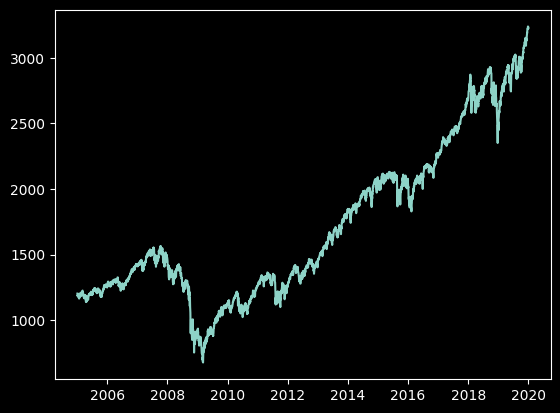

In [ ]:
# Notes:
# The Ichimoku Cloud strategy involves several components:
# 1. Tenkan-sen (Conversion Line): (9-period high + 9-period low) / 2
# 2. Kijun-sen (Base Line): (26-period high + 26-period low) / 2
# 3. Senkou Span A (Leading Span A): (Tenkan-sen + Kijun-sen) / 2, plotted 26 periods ahead
# 4. Senkou Span B (Leading Span B): (52-period high + 52-period low) / 2, plotted 26 periods ahead
# 5. Chikou Span (Lagging Span): Close price plotted 26 periods back
# Buy conditions:
# - The current price is above the cloud (Senkou Span A and Senkou Span B)
# - Tenkan-sen crosses above Kijun-sen

import yfinance as yf
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Define variables
STARTING_BALANCE = 10000

# Define time period
START = datetime.datetime(2005, 1, 1)
END = datetime.datetime(2020, 1, 1)
YEARS = (END - START).days / 365.25

# Load data into a pandas dataframe
symbol = "^GSPC"
price = yf.download(symbol, start=START, end=END)

# Drop redundant columns
price = price.drop(['High', 'Low', 'Volume', 'Adj Close'], axis=1)

# Plot chart
plt.style.use('dark_background')
plt.plot(price.Close)
plt.show()

# Calculate daily return
price['Return'] = price.Close / price.Close.shift(1)
price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()

# Calculate drawdown
price['Bench_Peak'] = price.Bench_Bal.cummax()
price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak
bench_dd = round((((price.Bench_DD / price.Bench_Peak).min()) * 100), 2)

# Ichimoku Cloud calculations
price['Tenkan_sen'] = (price['Close'].rolling(window=9).max() + price['Close'].rolling(window=9).min()) / 2
price['Kijun_sen'] = (price['Close'].rolling(window=26).max() + price['Close'].rolling(window=26).min()) / 2
price['Senkou_Span_A'] = ((price['Tenkan_sen'] + price['Kijun_sen']) / 2).shift(26)
price['Senkou_Span_B'] = ((price['Close'].rolling(window=52).max() + price['Close'].rolling(window=52).min()) / 2).shift(26)
price['Chikou_Span'] = price['Close'].shift(-26)

# Define entries
price['Long'] = (price['Close'].iloc[:,0] > price['Senkou_Span_A']) & (price['Close'].iloc[:,0] > price['Senkou_Span_B']) & (price['Tenkan_sen'] > price['Kijun_sen'])

# Calculate system balance
price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
price['Sys_Bal'] = STARTING_BALANCE * price.Sys_Ret.cumprod()

plt.plot(price.Bench_Bal)
plt.plot(price.Sys_Bal, color="red")
plt.show()

# Calculate drawdown
price['Sys_Peak'] = price.Sys_Bal.cummax()
price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak
sys_dd = round((((price.Sys_DD / price.Sys_Peak).min()) * 100), 2)

# Calculate metrics
bench_return = round(((price.Bench_Bal.iloc[-1] / price.Bench_Bal.iloc[1]) - 1) * 100, 2)
bench_cagr = round(((((price.Bench_Bal.iloc[-1] / price.Bench_Bal.iloc[1]) ** (1 / YEARS)) - 1) * 100), 2)
sys_return = round(((price.Sys_Bal.iloc[-1] / price.Sys_Bal.iloc[0]) - 1) * 100, 2)
sys_cagr = round(((((price.Sys_Bal.iloc[-1] / price.Sys_Bal.iloc[0]) ** (1 / YEARS)) - 1) * 100), 2)
sys_tim = round((price.Long.sum() / price.shape[0]) * 100, 2)

print(f'Benchmark Total return: {bench_return}%')
print(f'Benchmark CAGR: {bench_cagr}')
print(f'Benchmark DD: {bench_dd}%')
print('')
print(f'System Total return: {sys_return}%')
print(f'System CAGR: {sys_cagr}')
print(f'System DD: {sys_dd}%')
print(f'System Time in the Market: {sys_tim}%')

def backtest(price, conversion_period, base_period, leading_span_b_period):
    # Ichimoku Cloud calculations
    price['Tenkan_sen'] = (price['Close'].rolling(window=conversion_period).max() + price['Close'].rolling(window=conversion_period).min()) / 2
    price['Kijun_sen'] = (price['Close'].rolling(window=base_period).max() + price['Close'].rolling(window=base_period).min()) / 2
    price['Senkou_Span_A'] = ((price['Tenkan_sen'] + price['Kijun_sen']) / 2).shift(base_period)
    price['Senkou_Span_B'] = ((price['Close'].rolling(window=leading_span_b_period).max() + price['Close'].rolling(window=leading_span_b_period).min()) / 2).shift(base_period)
    price['Chikou_Span'] = price['Close'].shift(-base_period)

    # Define entries
    price['Long'] = (price['Close'].iloc[:,0] > price['Senkou_Span_A']) & (price['Close'].iloc[:,0] > price['Senkou_Span_B']) & (price['Tenkan_sen'] > price['Kijun_sen'])
    
    # On days when there is no trade, return is 1
    price['Sys_Return'] = np.where(price.Long.shift(1) == True, price.Return, 1)
    
    # Calculate balance
    price['Sys_Balance'] = STARTING_BALANCE * price.Sys_Return.cumprod()
    cagr_system = (((price.Sys_Balance.iloc[-1] / price.Sys_Balance.iloc[0]) ** (1 / YEARS)) - 1) * 100
    
    return cagr_system

conversion_periods = range(5, 20, 1)
base_periods = range(20, 40, 1)
leading_span_b_periods = range(40, 60, 1)

cagr = {}
results_full = []

for conversion in conversion_periods:
    results_base = []
    for base in base_periods:
        for leading_span_b in leading_span_b_periods:
            result = backtest(price, conversion, base, leading_span_b)
            results_base.append(result)
        results_full.append(results_base)

plt.figure(figsize=(12, 6))
sns.heatmap(results_full,
            cmap="coolwarm",
            xticklabels=base_periods,
            yticklabels=conversion_periods,
            linewidth=1,
            linecolor="black"
           )

max_cagr = max(list(map(max, results_full)))

for i, x in enumerate(results_full):
    if max_cagr in x:
        b = results_full[i].index(max_cagr)
        c = i

print(f'Conversion Period: {conversion_periods[c]}')
print(f'Base Period: {base_periods[b]}')
print(f'CAGR: {round(results_full[c][b], 2)}%')